In [1]:
import jax
# jax.config.update("jax_enable_x64", True)
# jax.config.update('jax_platform_name', 'cpu')
# jax.config.update("jax_debug_nans", True)
# jax.config.update("jax_disable_jit", True)
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
# import camb
from classy import Class # import classy module
from scipy.interpolate import interp1d
%matplotlib widget
log_folder = 'runs'

In [2]:
# import jax.profiler
# jax.profiler.start_server(9999)

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

cpu


In [4]:
from pylinger_background import evolve_background
from pylinger_perturbations import evolve_perturbations

In [5]:
## Cosmological Parameters
Tcmb = 2.7255
YHe = 0.248
Omegam = 0.276
Omegab = 0.0455
OmegaL = 1.0-Omegam
num_massive_neutrinos = 1
mnu=0.06 #0.06 #eV
Neff=2.046 # -1 if massive neutrino present
standard_neutrino_neff=Neff+num_massive_neutrinos
h = 0.703
A_s = 2.1e-9
n_s = 0.965
k_p = 0.05


In [6]:
# ## CAMB setup
# pars = camb.CAMBparams()
# #This function sets up with one massive neutrino and helium set using BBN consistency
# pars.set_cosmology(H0=100*h, ombh2=Omegab*h**2, omch2=(Omegam-Omegab)*h**2, mnu=mnu, omk=0, 
#                    tau=0.06, num_massive_neutrinos=num_massive_neutrinos,  
#                    nnu=Neff, YHe=YHe, TCMB=Tcmb )
# pars.InitPower.set_params(As=A_s, ns=n_s, r=0)
# pars.set_matter_power(redshifts=[99.], kmax=2.0)
# results = camb.get_results(pars)
# kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)

In [7]:
## CLASS setup
# create instance of the class "Class"
LambdaCDM = Class()
# pass input parameters
LambdaCDM.set({
    'Omega_b':Omegab,
    'Omega_cdm':(Omegam-Omegab),
    'N_ur':Neff,
    'N_ncdm':num_massive_neutrinos,
    'm_ncdm':mnu,
    'h':h,
    'A_s':A_s,
    'n_s':n_s,
    'tau_reio':0.06, 
    'gauge':'synchronous',
    # 'reio_parametrization' : 'reio_none',
    'k_per_decade_for_pk' : 100,
    'k_per_decade_for_bao' : 100,
    'compute damping scale' : 'yes',
    'tol_perturbations_integration' : 1e-07,
    'tol_background_integration' : 1e-07,
    'hyper_flat_approximation_nu' : 7000,
    'T_cmb':Tcmb,
    'YHe':YHe,
    'output':'mPk,mTk,vTk',
    'lensing':'no',
    'P_k_max_1/Mpc':10.0,
    'z_max_pk':1000.0,
    # these are high precision reference settings
    'start_small_k_at_tau_c_over_tau_h' : 0.0004,
    'start_large_k_at_tau_h_over_tau_k' : 0.05,
    'tight_coupling_trigger_tau_c_over_tau_h' : 0.005,
    'tight_coupling_trigger_tau_c_over_tau_k' : 0.008,
    'start_sources_at_tau_c_over_tau_h' : 0.006,
    'l_max_g' : 50,
    'l_max_pol_g' : 25,
    'l_max_ur' : 50,
    'l_max_ncdm' : 50,
  })
# run class
LambdaCDM.compute()
thermo = LambdaCDM.get_thermodynamics()

def get_class_power( fieldname, zout ):
  tk, k, z = LambdaCDM.get_transfer_and_k_and_z()
  TT = interp1d( np.log(1/(1+z)), tk[fieldname], axis=1 )( np.log(1/(1+zout)) ) 
  res =  2*np.pi**2*A_s*(k/k_p*h)**(n_s - 1) * k**(-3) * TT**2 *h**3
  return res, k

In [8]:
## Compute Background evolution
param = {}
param['Omegam'] = Omegam
param['Omegab'] = Omegab
param['OmegaL'] = OmegaL
param['Omegak'] = 0.0
param['A_s'] = A_s
param['n_s'] = n_s
param['H0'] = 100*h
param['Tcmb'] = Tcmb
param['YHe'] = YHe
param['Neff'] = Neff
param['Nmnu'] = num_massive_neutrinos
param['mnu'] = mnu

param = evolve_background(param=param)


In [9]:
# Compute Perturbations
nmodes = 128
kmin = 1e-5
kmax = 1e1
# aexp_out = jnp.array([1e-2,1e-1]) 
aexp_out = jnp.geomspace(1e-3,1,32)

y, kmodes = evolve_perturbations( param=param, kmin=kmin, kmax=kmax, num_k=nmodes, aexp_out=aexp_out )


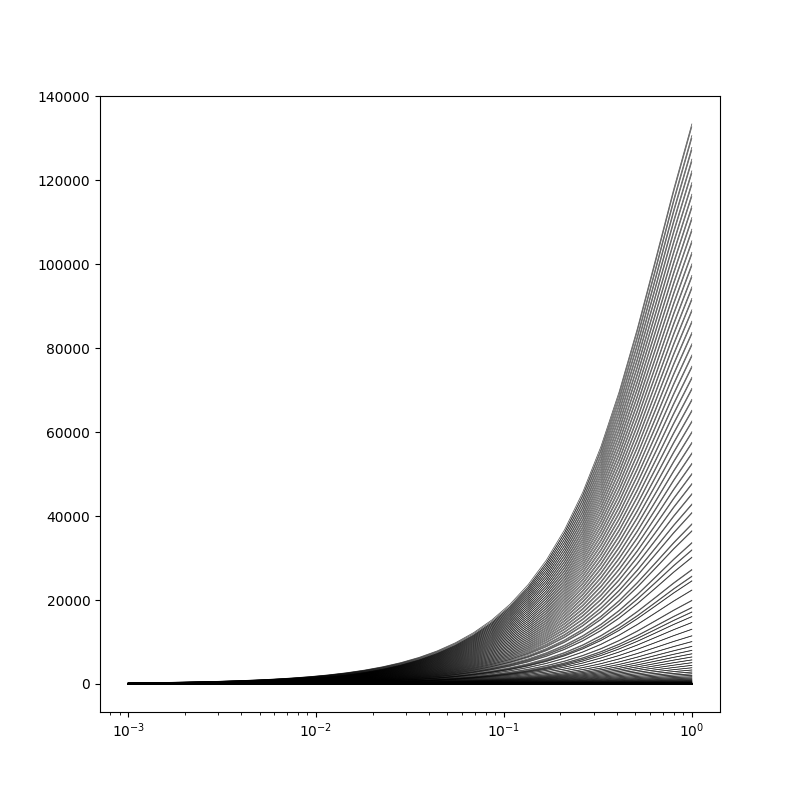

In [15]:
# plot evolution of density modes
fig, ax = plt.subplots(figsize=(8,8))
for i in range( y.shape[0] ):
    ax.semilogx( aexp_out, y[i,:,3], 'k-', alpha=0.7, lw=0.5, label='$\\delta_c$' )
    ax.semilogx( aexp_out, y[i,:,5], 'k-', alpha=0.7, lw=0.5, label='$\\delta_b$' )
    ax.semilogx( aexp_out, y[i,:,7], 'k-', alpha=0.7, lw=0.5, label='$\\delta_\\gamma$' )
    # ax.semilogx( aexp_out, y[i,:,9+2*4], label='$\\delta_\\nu$' )

# ax.loglog()
# ax.legend()

In [17]:
## evaluate the power spectra
iout = -1
print(f'pyEB zout={1/y[0,iout,0]-1}')
zout = jnp.maximum(1/y[0,iout,0]-1,0.0)

Pkc = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,3]**2 
Pkb = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,5]**2 
Pkg = A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,7]**2 

Pkc_CLASS, k_CLASS = get_class_power('d_cdm', zout)
Pkb_CLASS, k_CLASS = get_class_power('d_b', zout)

pyEB zout=-0.000567018985748291


(0.0001, 10)

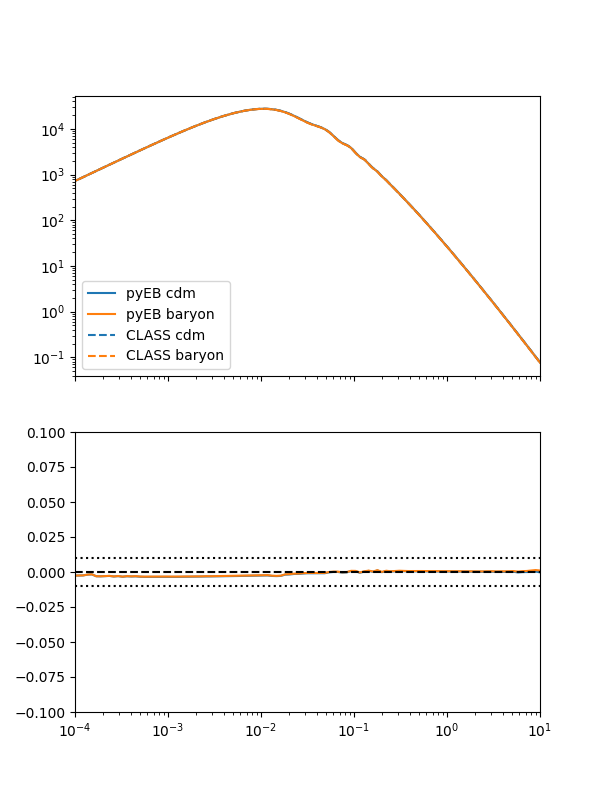

In [18]:
# plot power spectra against CLASS result

fig, ax = plt.subplots(2,1, sharex=True, figsize=(6,8) )
fac = 2.5
# fac = 2*np.pi**2/ (2*np.pi)**1.5 
ax[0].loglog( kmodes, Pkc*fac,label='pyEB cdm', color='C0')
# ax.loglog( kmodes, Pkc_CAMB, label='CAMB cdm', color='C0', ls='--')
ax[0].loglog( kmodes, Pkb*fac,label='pyEB baryon', color='C1') 
# ax.loglog( kmodes, Pkb_CAMB, label='CAMB baryon', color='C1', ls='--')
ax[0].loglog( k_CLASS, Pkc_CLASS, label='CLASS cdm', ls='--', color='C0')
ax[0].loglog( k_CLASS, Pkb_CLASS, label='CLASS baryon', ls='--', color='C1')
ax[0].legend()

ax[1].semilogx( kmodes, Pkc*fac/np.exp(np.interp( np.log(kmodes), np.log(k_CLASS), np.log(Pkc_CLASS) ))-1.0, label='cdm err', color='C0')
ax[1].semilogx( kmodes, Pkb*fac/np.exp(np.interp( np.log(kmodes), np.log(k_CLASS), np.log(Pkb_CLASS) ))-1.0, label='baryon err', color='C1')

ax[1].set_ylim((-0.1,0.1))
ax[1].axhline(0.0, ls='--', color='k')
ax[1].axhline(0.01, ls=':', color='k')
ax[1].axhline(-0.01, ls=':', color='k')

ax[1].set_xlim((1e-4,10))

# ax.loglog( kmodes, Pkg, label='pyEB photon', color='C2') 
# ax.set_xlim((1e-3,5))

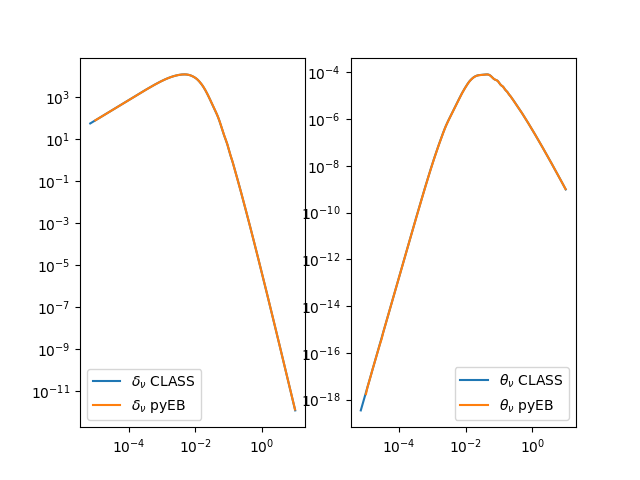

In [19]:
fig, ax = plt.subplots(1,2)

Pd,kd = get_class_power('d_ncdm[0]', zout)
Pt,kt = get_class_power('t_ncdm[0]', zout)
ax[0].loglog( kd, Pd, label='$\\delta_\\nu$ CLASS')
ax[0].loglog( kmodes, fac*A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,-3]**2, label='$\\delta_\\nu$ pyEB' )

ax[1].loglog( kt, Pt, label='$\\theta_\\nu$ CLASS')
ax[1].loglog( kmodes, fac*A_s*(kmodes/k_p)**(n_s - 1) * kmodes**(-3) * y[:,iout,-2]**2, label='$\\theta_\\nu$ pyEB' )

ax[0].legend()
ax[1].legend()


Text(0.5, 0, '$a$')

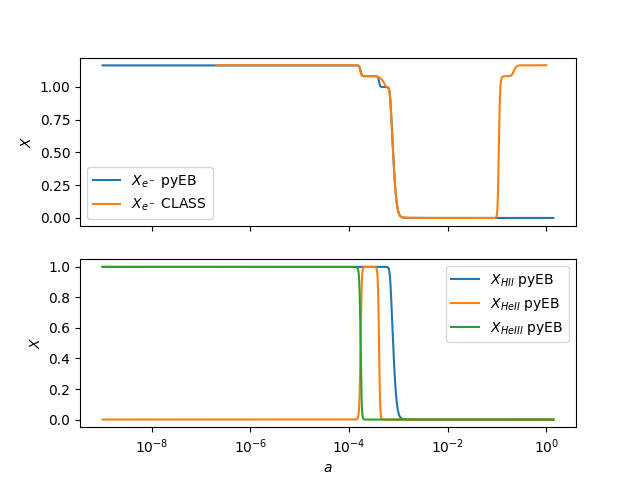

In [21]:
# plot thermal evolution
fg, ax = plt.subplots(2,sharex=True)
ax[0].semilogx( param['th']['a'], param['th']['xe'], label='$X_{e^-}$ pyEB' )
ax[0].semilogx( 1/(1+thermo['z']), thermo['x_e'], label='$X_{e^-}$ CLASS' )
ax[1].semilogx( param['th']['a'], param['th']['xHII'], label='$X_{HII}$ pyEB' )
ax[1].semilogx( param['th']['a'], param['th']['xHeII'], label='$X_{HeII}$ pyEB' )
ax[1].semilogx( param['th']['a'], param['th']['xHeIII'], label='$X_{HeIII}$ pyEB' )
for a in ax: 
  a.legend()
  a.set_ylabel('$X$')

ax[1].set_xlabel('$a$')